In [1]:
# !pip install transformers

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import gc
import os
import pickle
import torch
import random
from torch.nn import BCEWithLogitsLoss, BCELoss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score
from transformers import AutoModel,BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold,KFold
from torch.nn.functional import softmax
from transformers import logging
logging.set_verbosity_warning()
from transformers import AutoConfig, AutoTokenizer, AutoModel
import time
import datetime
import seaborn as sns
from preprocess_ import cleaner


tqdm.pandas()

In [2]:
import re
df = pd.read_csv("./df_drop_duplicates.csv", index_col=0)

df = df[~df.sentiment.isna()]
df = df[df.sentiment != "در مورد خرید این محصول مطمئن نیستم"]
df.reset_index(inplace=True, drop=True)
df['comments'] = df['comments'].astype(str).progress_apply(lambda x: cleaner(x))

100%|██████████████████████████████| 2554911/2554911 [00:49<00:00, 51974.18it/s]


In [4]:
df.shape

(2554911, 2)

In [5]:
df.sentiment.value_counts()

sentiment
خرید این محصول را توصیه می‌کنم     2145345
خرید این محصول را توصیه نمی‌کنم     409566
Name: count, dtype: int64

In [7]:
cat_mapper = dict(zip(df.sentiment.unique(), [0,1]))

df.sentiment = df.sentiment.map(cat_mapper)
cat_mapper

{'خرید این محصول را توصیه می\u200cکنم': 0,
 'خرید این محصول را توصیه نمی\u200cکنم': 1}

In [8]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()

df = df.dropna()

X = df.loc[:,["comments"]]
Y = df.sentiment
Y.value_counts()

sentiment
0    2145345
1     409566
Name: count, dtype: int64

In [9]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

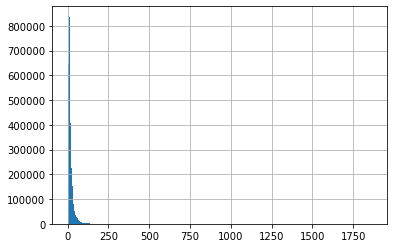

In [10]:
seq_len = [len(i.split()) for i in X['comments']]
pd.Series(seq_len).hist(bins = 300)

In [11]:
max_length = 64
num_labels = 2

In [12]:
X['len'] = seq_len
X.loc[X['len']>max_length,'comments'] = X.loc[X['len']>max_length,'comments'].str[-max_length:]
X = X['comments']


In [13]:
def make_model():
    model = BertForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",num_labels=23,output_hidden_states = False)
    model = model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,eps = 1e-8,correct_bias=True)
    return model, optimizer

In [14]:
def flat_evaluation(preds, preds_, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    f1_micro = f1_score(labels_flat,pred_flat,average="micro")
    f1_macro = f1_score(labels_flat,pred_flat,average="macro")

    preds_ = [i[1] for i in preds_]
    auc = roc_auc_score(labels_flat,preds_)

    return acc, f1_micro ,f1_macro ,auc

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
all_LOGITS = []
all_LOGITS_ = []
all_LABELS = []

batch_size = 64
train_loss_set = []
loss_values = []
ACC,AUC =[],[]
pred=[]
valid=[]
predprob_li_logits=[]
predprob_li_logits_=[]
predprob_li_labels=[]
counter = -1
epochs = 4

del df
gc.collect()
# skf=KFold(n_splits=5,random_state=2)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
fold=0
for i,(train_index, test_index) in enumerate(kf.split(X , Y)):

    model, optimizer = make_model()
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = Y.iloc[train_index].values, Y.iloc[test_index].values
    valid.append(test_index)
    encodings_train = tokenizer.batch_encode_plus(X_train.tolist(),max_length=max_length,pad_to_max_length=True)
    encodings_test = tokenizer.batch_encode_plus(X_test.tolist(),max_length=max_length,pad_to_max_length=True)
                                     
    input_ids = encodings_train['input_ids']# tokenized and encoded sentences
    token_type_ids = encodings_train['token_type_ids'] # token type ids
    attention_masks = encodings_train['attention_mask'] # attention masks

    input_ids_ = encodings_test['input_ids']# tokenized and encoded sentences
    token_type_ids_ = encodings_test['token_type_ids'] # token type ids
    attention_masks_ = encodings_test['attention_mask']

    train_inputs = torch.tensor(input_ids)
    train_labels = torch.tensor(y_train)
    train_masks = torch.tensor(attention_masks)
    train_token_types = torch.tensor(token_type_ids)

    test_inputs = torch.tensor(input_ids_)
    test_labels = torch.tensor(y_test)
    test_masks = torch.tensor(attention_masks_)
    test_token_types = torch.tensor(token_type_ids_)


    train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0
        model.train()
        

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 400 == 1 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()        
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.5f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        # Tracking variables 
        eval_loss, eval_accuracy,eval_f1,eval_auc = 0, 0,0,0
        nb_eval_steps, nb_f1_eval_steps ,nb_eval_examples, nb_auc_eval_steps = 0, 0 ,0, 0

        LOGITS, LOGITS_, LABELS = [], [], []
        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels ,b_token_types= batch
            with torch.no_grad():        
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)

            logits = outputs[0]
            logits_ = softmax(logits)
#             print(logits)
            # Move logits and labels to CPU
            LOGITS += list(logits.detach().cpu().numpy().tolist())
            LOGITS_ += list(logits_.detach().cpu().numpy())
            LABELS += list(b_labels.to('cpu').numpy().tolist())
        predprob_li_logits.append(LOGITS)
        predprob_li_logits_.append(LOGITS_)
        predprob_li_labels.append(LABELS)
          
        acc, f1_micro ,f1_macro ,auc = flat_evaluation(LOGITS, LOGITS_, LABELS)
        print("  Accuracy: {0:.5f}".format(acc))
        print("  f1: {0:.5f}".format(f1_micro))
        print("  AUC: {0:.5f}".format(auc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        torch.save(model.state_dict(),'./model_{}_{}'.format(i,epoch_i))

    all_LOGITS += LOGITS
    all_LOGITS_ += LOGITS_
    all_LABELS += LABELS
    print("")
    print("Training complete!")    
    
    del X_train, y_train
    gc.collect()
    

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica